## Performing (true) ROBUST meta learning with the Khazad-Dum enviornment

This code is to demonstrate that I can do true RMRL with the KD environment - that is, sampling tasks, learning for them, and only keeping the worst ones

In [30]:
#Perform imports
import random
from math import floor

import numpy as np
import torch
from torch import optim
from tqdm import tqdm

import gymnasium as gym


from stable_baselines3 import A2C

from stable_baselines3.common.logger import configure


import matplotlib.pyplot as plt


device = 'cpu'# 'cuda' #  #doing cpu as A2C with MlpPolicy (rather than CNNpolicy) in stablebaseline is faster on CPU, and the meta gradinet beign faster on GPU (even if it is) is not *that* much faster - it is about two(ish) times slower overall based on one run each with two meta iterations, so better on cpu in this case
torch.set_default_device(device)

In [80]:
model_save_path = "saved_models\\13May25_2_metalearningKD_robust"


In [81]:
import os
os.mkdir(model_save_path)

In [79]:
##Set up for meta learning

#Hyperparameters
adapt_lr =  7e-4
meta_lr = 0.0005 

meta_iterations = 10#500#1250
tasks_per_loop = 40#60
adapt_timesteps = 32*4 #for this enviornment, each episode is exactly 32 timesteps, so multiple of 32 means full number of eps experienced for each task
M = 5 #number of sampled adapted policies for each task (to see quality of meta parameters for this task in terms of mean performance, for more reliable targetting of dangerous tasks)

adapt_visualisations = 15



vis_timesteps = meta_iterations//adapt_visualisations #denominator is number of visualisations we want
if vis_timesteps == 0:
    vis_timesteps = 1 

#Make meta-environment
import fabian.envs.khazad_dum_gymn 
env = gym.make("KhazadDum-v1") # can access wrapped env with "env.unwrapped" (e.g. to reset task)
env.unwrapped.exp_bonus = 1; env.unwrapped.bridge_bonus_factor = 2 #this should incentivise getting to the target asap

#Make meta-policy and meta-optimiser
meta_agent = A2C("MlpPolicy", env, verbose=0, meta_learning=True, learning_rate=adapt_lr, device=device) #we train the meta_agent to do well at adapting to new envs (i.e. meta learning) in our env distribution
meta_opt = optim.Adam(meta_agent.policy.parameters(), lr=meta_lr)

#Logging variables
meta_losses = []
meta_rets = []
best_meta_ret = None
best_meta_ret_it = -1

c:\Users\fabia\anaconda3\envs\learn2learn_newtorch\Lib\site-packages\gymnasium\envs\registration.py:487: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes']
  logger.warn(


issue: currently, each meta loop goes through a bunch of tasks and for each task trains up a single adapted agent with all the timesteps (hence all the trajectories) for this task. It then gets the gradient of the agent's 'adaptation loss' with respect to the initial parameters, and that is our judgement for the task.

----

In MAML, this I think is exactly what is going on - we sample K trajectories (c. equiv. we limit by number of timesteps ig), then adapt a parameter once to the loss w.r.t all these trajdectories and then find the meta-loss. 

----

But in RoML, we sample several tasks from our distribution, calculate several rollouts for each task, then compute the mean return for each task, then the CVaR loss , and then meta learn using these rollouts. 

That is, we need to reliably estimate which tasks are worst, and only use our adaptation loss against these worst tasks for our gradient updates. In the RoML paper, this is evaluating our *current* policy on our tasks - but importantly, our policy is a META POLICY; so evaluating it to a task means adapting it to the task the amount we intend to adapt ({adapt_timesteps} timesteps), and then seeing what the adaptation loss and return is. We want to do this a few times for each task to get a good feel for the quality of each task, and then average our over them (unlike before, where we could just do a single task and our meta learning averages over them because we treat each task the same so dont need several samples to know which ones are more dangerous and thefore reliably discard safe tasks). 

So what we will do, is for each task sample M adapted policies for each task (each adapted with adapt_timesteps timesteps), and find the mean adaptation loss and mean return over the task. We store the lists of mean adaptation losses and mean returns over tasks. We then do the CVaR of this, keeping the worst mean adaptation losses, taking a mean of means, and then using this value to backpropagate.  

In [ ]:
def quickselect(lst, n):
    """
    Returns nth order statistic of lst, with n 1-indexed s.t.  quickselect(lst,1)=min(quickselect)
    """
    if len(lst) == 1:
        return lst[0]
    
    pivot = random.choice(lst)
    lows = [x for x in lst if x < pivot]
    highs = [x for x in lst if x > pivot]
    pivots = [x for x in lst if x == pivot]

    if n <= len(lows):
        return quickselect(lows, n)
    elif n <= len(lows) + len(pivots):
        return pivots[0]
    else:
        return quickselect(highs, n - len(lows) - len(pivots))
    
#HAS BEEN TESTED QUICKLY THROUGH TESTING THE CVaR INDICES FUNCTION

In [ ]:
def get_CVaR_keep_indices(xs, alpha, keep_lowest = True):
    """
    Returns the indices of xs which are in the {bottom if keep_lowest else top} alpha-percentile of the values in xs 
    """
    num_to_keep = floor(len(xs)*alpha)
    assert num_to_keep >= 1

    n_order_stat = num_to_keep if keep_lowest else len(xs)-num_to_keep+1
    cutoff = quickselect(xs, n_order_stat) #sorted(xs)[n_order_stat-1]#

    indices = []
    for i in range(len(xs)):
        if keep_lowest and xs[i]<=cutoff:
            indices.append(i)
        elif (not keep_lowest) and xs[i]>=cutoff:
            indices.append(i) 
    
    return indices

#TESTED QUICKLY
    

In [74]:
def get_CVaR(xs, alpha, keep_lowest = True):
    """
    Returns the mean of values in xs which are in the {bottom if keep_lowest else top} alpha-percentile of the values in xs 
    """
    indices = get_CVaR_keep_indices(xs, alpha, keep_lowest)
    keep_vals = [xs[i] for i in indices]
    
    sum = 0
    for val in keep_vals:
        sum += val

    mean = sum/len(keep_vals)
    
    return mean

In [ ]:
#Outer CVaR  meta-learning loop - each iteration performs one gradient update step on our meta parameters
for meta_it in tqdm(range(meta_iterations)):
    mean_loss_bytask = []; mean_ret_bytask = []

    #Have agent adapt to ALL tasks one by one
    for t in (range(tasks_per_loop)):
        env.unwrapped.reset_task() #randomly selects task from environment to reset it to

        task_mean_loss = 0; task_mean_ret = 0

        for m in range(M): #we adapt to the task M times to find average adaptation performance
            env.unwrapped.reset_task(task=env.unwrapped.action_noise) #env.unwrapped.action_noise is a standin for env.unwrapped.task for KD env - this resets the environment without changing the task

            meta_agent.learn(total_timesteps=adapt_timesteps) #adapt (a clone of) the meta agent to this task

            adaptation_loss, a_rets = meta_agent.run_meta_adaption_and_loss(total_timesteps=100) #sample {total_timesteps} worth of timesteps from task and get loss of adapted agent
                
            task_mean_loss += adaptation_loss; task_mean_ret += a_rets

        task_mean_loss /= M; task_mean_ret /= M
        mean_loss_bytask.append(task_mean_loss); mean_ret_bytask.append(task_mean_ret)


    #Filter {mean_loss_bytask}, {mean_ret_bytask} by CVaR
    indices = get_CVaR_keep_indices(mean_ret_bytask, 0.1, keep_lowest=True) #TODO: doing CVaR filtering by RETURN here; could also be done via LOSS
                #^ we want to keep the lowest (worst) returns and the highest (worst) losses
    keep_losses = [mean_loss_bytask[i] for i in indices]
    keep_rets = [mean_ret_bytask[i] for i in indices]
    
    total_cvar_loss = 0
    for loss in keep_losses: total_cvar_loss+=loss
    total_cvar_loss/=len(keep_losses) #normalise by the number of tasks in our CVaR (so it is still loss/task)

    total_cvar_rets = 0
    for ret in keep_rets: total_cvar_rets+=ret
    total_cvar_rets/=len(keep_rets)

    

    #Perform gradient update on meta learning parameters
    meta_opt.zero_grad()
    total_cvar_loss.backward()
    meta_opt.step()

    #Save(/override) the best performing model (w.r.t CVaR performance against adaptation task set)
    if best_meta_ret is None or total_cvar_rets>best_meta_ret :
        best_meta_ret = total_cvar_rets
        best_meta_ret_it = meta_it
        torch.save(meta_agent.policy.state_dict(), f"{model_save_path}\\best_val_meta_ret") #OK to just save {model.policy} as that is all being meta-optimised
            #TODO: could it be that the highest return happens before the end of training because actually it then optimises loss and that gets us to the target in a way that return doesnt capture? not sure that makes sense so probs not....??? unlike loss being wierd before the critic is trained (I think thta is the source of the wierdness) return should always tell us whats good and what isnt rihgt?

    #Track meta_training curve
    meta_losses.append(total_cvar_loss.detach().item())
    meta_rets.append(total_cvar_rets.item())


    if meta_it % vis_timesteps == 0:
        #Output training info to console
        print(f"Meta loop {meta_it+1}/{meta_iterations} complete, validation loss: {total_cvar_loss.detach().item()}, validation return: {total_cvar_rets}")

        #Qualitative plot of adapted policy
        fig, ax = plt.subplots()
        ax = env.unwrapped.show_state(ax)    
        fig.show()

        #Save meta model
        torch.save(meta_agent.policy.state_dict(), f"{model_save_path}\\meta_it_{meta_it}")


  0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
torch.save(meta_agent.policy.state_dict(), f"{model_save_path}\\final")


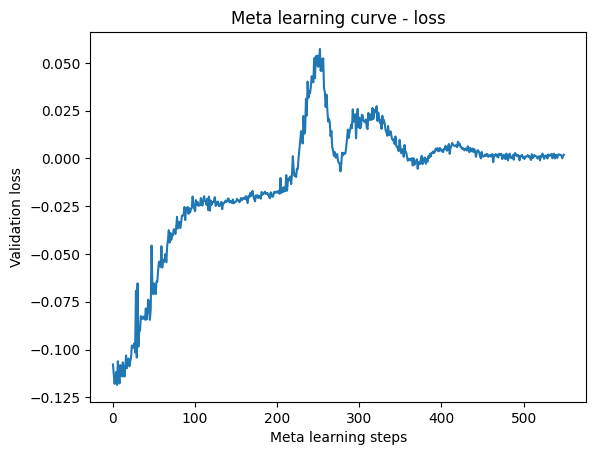

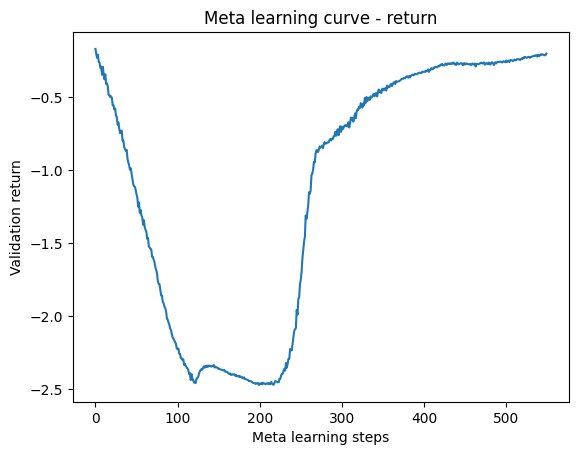

In [8]:
##Plot meta learning curves
xs = range(len(meta_losses))

plt.plot(xs, meta_losses)
plt.xlabel('Meta learning steps')
plt.ylabel('Validation loss')
plt.title('Meta learning curve - loss')
plt.show()

plt.plot(xs, meta_rets)
plt.xlabel('Meta learning steps')
plt.ylabel('Validation return')
plt.title('Meta learning curve - return')
plt.show()

In [6]:
#Load in enviornemnt that performed best against meta validation
loaded_meta_agent = A2C("MlpPolicy", env, verbose=0, meta_learning=True, learning_rate=adapt_lr, device=device)
loaded_meta_agent.policy.load_state_dict(torch.load(f"{model_save_path}\\final", weights_only=True)) 
    #can also load in intermediate saved envs from training

<All keys matched successfully>

100%|██████████| 9/9 [00:30<00:00,  3.41s/it]
C:\Users\fabia\AppData\Local\Temp\ipykernel_50520\1616935474.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


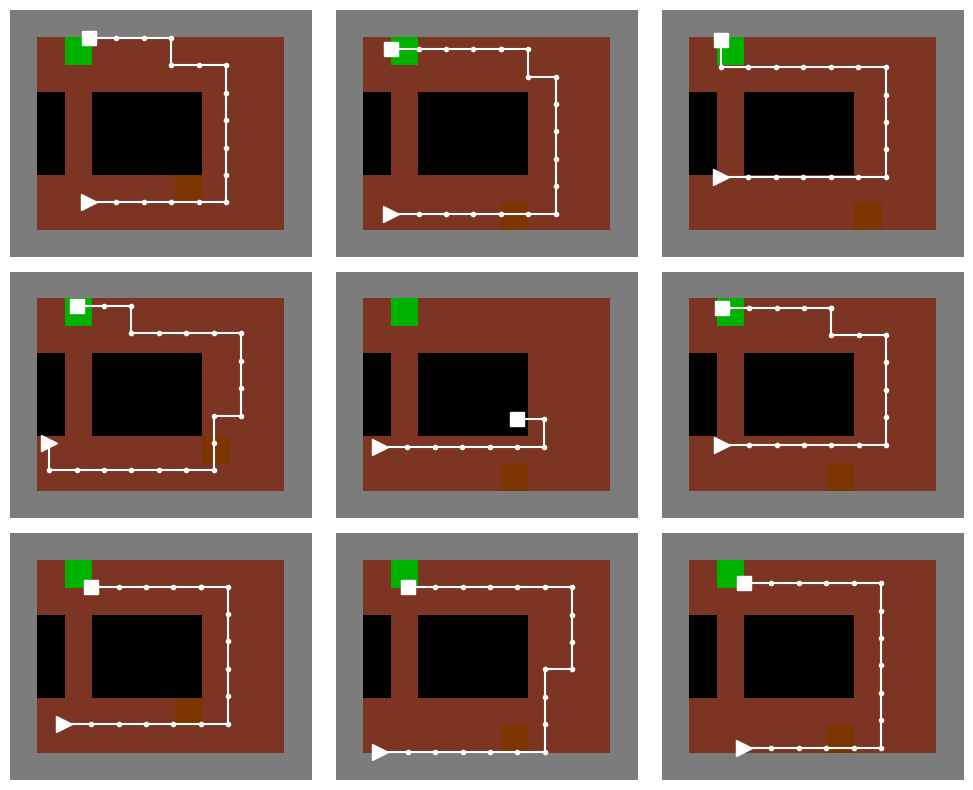

In [7]:
#Seeing it manage in a range of environments - this one is taken from loading the best model from a 400 meta-step training, which clearly isnt quite all that 
dim = 3
fig, axs = plt.subplots(dim, dim, figsize=(10, 8))

for t in tqdm(range(dim*dim)):
    #Perform few shot adaption to environment
    env.unwrapped.reset_task() #randomly selects task from environment to reset it to
    loaded_meta_agent.learn(total_timesteps=adapt_timesteps) #adapt the meta agent to this task

    #Test against a new trajectory from that state (else we are showing something it trained to and before the final training step)
    loaded_meta_agent.run_meta_adaption_and_loss(total_timesteps=32)

    #Plot this run
    x = t//dim
    y = t%dim
    axs[x,y] = env.unwrapped.show_state(axs[x,y])    
    axs[x,y].set_axis_off()
    
plt.tight_layout()
fig.show()


#TODO: i should do this again with a non meta-trained model that just learns for a single task and see how it does worse qualitatively